In [1]:
#Libraries required
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits import mplot3d
import seaborn as sns
import statsmodels.api as sm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
import io 
import tempfile
import os 
from io import BytesIO
import base64
from collections import Counter


In [2]:
# Function for data preprocessing
def data_preprocessing(input_file):
    df = pd.read_csv(input_file)
    df = df.sort_values(by=['local_date', 'hour'], inplace=False)
    df = df[['local_date', 'hour', 'compliant_min']]
    df = df.reset_index(drop=True)
    df['local_date'] = pd.to_datetime(df['local_date'])
    
    # Filling NA or compliant_min=0 for the missing hours
    start_date = df['local_date'].min()
    end_date = df['local_date'].max()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    all_dates_df = pd.DataFrame({'local_date': date_range})
    all_hours = range(24)
    all_hours_df = pd.DataFrame({'hour': all_hours})
    all_dates_hours_df = all_dates_df.assign(key=1).merge(all_hours_df.assign(key=1), on='key').drop('key', axis=1)
    merged_df = all_dates_hours_df.merge(df, on=['local_date', 'hour'], how='left')
    merged_df['compliant_min'] = merged_df['compliant_min'].fillna(0)
    df = merged_df.sort_values(['local_date', 'hour']).reset_index(drop=True)
    
    # New Column 'day' for the unique dates
    unique_days = df['local_date'].dt.date.unique()
    day_names = {day: f'day{i+1}' for i, day in enumerate(unique_days)}
    df['day'] = df['local_date'].dt.date.map(day_names)
    df = df.reset_index(drop=True)
    
    return df

In [3]:
def generate_heatmap(df):
    # Create a copy of the dataframe
    patient_heat_map = df.copy()

    # Convert 'compliant_min' to integer
    patient_heat_map['compliant_min'] = patient_heat_map['compliant_min'].astype(int)

    # Get unique days in the DataFrame
    unique_days = patient_heat_map['day'].unique()
    unique_days = sorted(unique_days, key=lambda x: int(x[3:]))  # Sort the days numerically

    # Pivot the data
    pivot_data = patient_heat_map.pivot('hour', 'day', 'compliant_min')

    # Reorder the columns based on the sorted unique days
    pivot_data = pivot_data[unique_days]

    # Increase the figure size for better visibility
    plt.figure(figsize=(18, 6))

    # Creating the heatmap
    sns.heatmap(pivot_data, cmap='RdYlGn', vmin=0, vmax=60, cbar=True, linewidths=0.5, linecolor='gray')

    # Add lines to separate hours and days
    plt.hlines(y=range(0, len(pivot_data.index)), xmin=0, xmax=len(pivot_data.columns), color='gray', linewidths=0.5)
    plt.vlines(x=range(0, len(pivot_data.columns)), ymin=0, ymax=len(pivot_data.index), color='gray', linewidths=0.5)

    # Customize the plot
    #plt.title('Compliant Minutes Heatmap', fontsize=16)
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Hour', fontsize=14)

    # Increase the font size of the x-axis and y-axis labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Save the plot to a BytesIO object
    plot_bytes = io.BytesIO()
    plt.savefig(plot_bytes, format='png', dpi=400)  # Increase the dpi for higher resolution
    plt.show()
    plt.close()

    # Reset the buffer position to the start
    plot_bytes.seek(0)

    # Return the BytesIO object
    return plot_bytes


In [35]:
# Function to perform Apriori algorithm and generate vertical report
def apriori_vertical_report(df):
    df = df[df['compliant_min'] < 35]

    # Group the DataFrame by 'day'
    grouped_by_day = df.groupby('day')

    # Filter and keep only the days with more than 6 rows where 'compliant_min' is less than 30
    filtered_days = grouped_by_day.filter(lambda x: (x['compliant_min'] < 35).sum() > 6)

    # Filter the DataFrame for each hour
    filtered_data = []
    for hour in range(24):
        hour_data = filtered_days[filtered_days['hour'] == hour]['day'].tolist()
        filtered_data.append(tuple(hour_data))

    # Store the filtered data as a tuple
    filtered_data_tuple = tuple(filtered_data)

    # Count the occurrences of each day across all hours
    day_counts = Counter([day for hour_data in filtered_data_tuple for day in hour_data])

    # Get the days that occurred at least 5 times
    days_to_keep = set(day for day, count in day_counts.items() if count >= 5)

    # Filter the tuples by removing the days that occurred fewer than 8 times
    filtered_data_tuple_filtered = tuple([tuple(day for day in hour_data if day in days_to_keep) for hour_data in filtered_data_tuple])

    # Convert the filtered_data_tuple_filtered into a list of transactions
    transactions = list(filtered_data_tuple_filtered)

    # Initialize TransactionEncoder
    te = TransactionEncoder()
    # Apply TransactionEncoder to the list of transactions
    te_ary = te.fit(transactions).transform(transactions)
    # Convert the encoded array into a DataFrame
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Apply Apriori algorithm to find frequent itemsets
    frequent_itemsets = apriori(df_encoded, min_support=0.6, use_colnames=True)

    # Sort the frequent itemsets by support in descending order
    frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

    # Dropping duplicates
    frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(frozenset)
    frequent_itemsets = frequent_itemsets.drop_duplicates(subset='itemsets')
    frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(set)

    # Filter the DataFrame to get itemsets with support of 0.5
    filtered_itemsets = frequent_itemsets[frequent_itemsets['support'] > 0.5]

    # Sorting the DataFrame by the length of the itemsets column in ascending order
    filtered_itemsets = filtered_itemsets.iloc[sorted(range(len(filtered_itemsets)), key=lambda x: len(filtered_itemsets['itemsets'].iloc[x]))]

    # Step 1: Create a new DataFrame new_filtered_itemset with support value == 1 and itemsets length == 1
    new_filtered_itemset = filtered_itemsets[(filtered_itemsets['support'] == 1) & (filtered_itemsets['itemsets'].apply(len) == 1)].copy()

    # Step 2: Find the largest itemset from filtered_itemsets
    largest_itemset = max(filtered_itemsets['itemsets'], key=len)

    # Step 3: Add the largest_itemset to new_filtered_itemset with its original support
    largest_support = filtered_itemsets.loc[filtered_itemsets['itemsets'] == largest_itemset, 'support'].values[0]
    new_filtered_itemset = new_filtered_itemset.append({'support': largest_support, 'itemsets': largest_itemset}, ignore_index=True)

    # Step 4: Iteratively add non-subset itemsets to new_filtered_itemset
    for itemset in filtered_itemsets['itemsets']:
        if not itemset.issubset(largest_itemset):
            support_val = filtered_itemsets.loc[filtered_itemsets['itemsets'] == itemset, 'support'].values[0]
            new_filtered_itemset = new_filtered_itemset.append({'support': support_val, 'itemsets': itemset}, ignore_index=True)

    
    
    
    
    
    new_filtered_itemset = new_filtered_itemset[new_filtered_itemset['support']>0.5]

    # Modify the itemsets column to remove 'frozenset' and display cleaner visualization
    new_filtered_itemset['itemsets'] = new_filtered_itemset['itemsets'].apply(lambda x: ", ".join(str(item) for item in x))

    # Visualize the support values for new_filtered_itemset
    plt.barh(range(len(new_filtered_itemset)), new_filtered_itemset['support'], color='blue')
    plt.yticks(range(len(new_filtered_itemset)), new_filtered_itemset['itemsets'])
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.title('Apriori Algorithm - Itemset Support')
    plt.show()
    plt.close()
    return new_filtered_itemset


In [30]:
def apriori_horizontal_report(df):
    plot_reports = []  # List to store plots
    interpretations = []  # List to store print statements
    
    def get_time_of_day(hour):
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 24:
            return 'Evening'
        else:
            return 'Night'

    # Apply the function to the 'hour' column and create a new column 'time_of_day'
    df['time_of_day'] = df['hour'].apply(get_time_of_day)

    # Iterate over the unique dates and extract the hours where compliant time is less than 40
    hours_less_than_40 = []
    for date in df['local_date'].dt.date.unique():
        filtered_data = df[df['local_date'].dt.date == date]
        filtered_data_less_than_40 = filtered_data[filtered_data['compliant_min'] < 45]
        hours_filtered = tuple(filtered_data_less_than_40['hour'])
        hours_less_than_40.append((date, hours_filtered))

    # Convert data into transaction format
    transactions_of_hours = [itemset[1] for itemset in hours_less_than_40]
    
    print("Day wise transaction of hours where compliance time is less than 40 min : \n",transactions_of_hours)

    # Convert the transaction data to a one-hot encoded format
    te = TransactionEncoder()
    te_ary = te.fit(transactions_of_hours).transform(transactions_of_hours)
    df_hours = pd.DataFrame(te_ary, columns=te.columns_)
    print("Final Input for Apriori Algorithm for Horizontal Pattern : \n")
    #df_hours.to_csv('input_for_apriori.csv')
    # Apply Apriori algorithm to find frequent itemsets
    frequent_itemsets_hours = apriori(df_hours, min_support=0.2, use_colnames=True)

    # Sort the frequent itemsets by support in descending order
    frequent_itemsets_hours = frequent_itemsets_hours.sort_values(by='support', ascending=False)

    # Dropping duplicates
    frequent_itemsets_hours['itemsets'] = frequent_itemsets_hours['itemsets'].apply(frozenset)
    frequent_itemsets_hours = frequent_itemsets_hours.drop_duplicates(subset='itemsets')
    frequent_itemsets_hours['itemsets'] = frequent_itemsets_hours['itemsets'].apply(set)
    print(frequent_itemsets_hours)
    # Filter the DataFrame to get itemsets with support of 0.4
    filtered_itemsets = frequent_itemsets_hours[frequent_itemsets_hours['support']>0.5]

    # Modify the itemsets column to remove 'frozenset' and display cleaner visualization
    filtered_itemsets['itemsets'] = filtered_itemsets['itemsets'].apply(lambda x: ", ".join(str(item) for item in x))
    print(filtered_itemsets)

    # Visualize the support values
    plt.barh(range(len(filtered_itemsets.head(10))), filtered_itemsets['support'], color='blue')
    plt.yticks(range(len(filtered_itemsets.head(10))), filtered_itemsets['itemsets'])
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.title('Apriori Algorithm - Itemset Support')
    plt.show()
    plt.close()

    # Print the top three itemsets
    top_itemsets_statement = "\n"
    for index, row in filtered_itemsets.head(5).iterrows():
        top_itemsets_statement += f"-The patient is not compliant for the hours taken from itemset: {row['itemsets']}, with a support of {row['support']}."
    interpretations.append(('',top_itemsets_statement))

    time_of_day_40 = []
    for date in df['local_date'].dt.date.unique():
        filtered_data = df[df['local_date'].dt.date == date]
        filtered_data['time_of_day'] = filtered_data['hour'].apply(get_time_of_day)
        filtered_data_less_than_40 = filtered_data[filtered_data['compliant_min'] < 40]
        time_of_day_filtered = tuple(filtered_data_less_than_40['time_of_day'])
        time_of_day_40.append((date, time_of_day_filtered))

    # Convert data into transaction format
    transactions_of_time_of_day = [itemset[1] for itemset in time_of_day_40]

    # Convert the transaction data to a one-hot encoded format
    te = TransactionEncoder()
    te_ary = te.fit(transactions_of_time_of_day).transform(transactions_of_time_of_day)
    df_time_of_day = pd.DataFrame(te_ary, columns=te.columns_)

    # Apply Apriori algorithm to find frequent itemsets
    frequent_itemsets_day = apriori(df_time_of_day, min_support=0.4, use_colnames=True)

    # Sort the frequent itemsets by support in descending order
    frequent_itemsets_day = frequent_itemsets_day.sort_values(by='support', ascending=False)

    # Get the most frequent itemsets
    frequent_itemsets_day = frequent_itemsets_day.head(15)

    # Modify the itemsets column to remove 'frozenset' and display cleaner visualization
    frequent_itemsets_day['itemsets'] = frequent_itemsets_day['itemsets'].apply(lambda x: ", ".join(str(item) for item in x))

    # Visualize the support values
    plt.barh(range(len(frequent_itemsets_day)), frequent_itemsets_day['support'], color='blue')
    plt.yticks(range(len(frequent_itemsets_day)), frequent_itemsets_day['itemsets'])
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.title('Apriori Algorithm - Itemset Support')
    plt.show()
    plt.close()

    # Print the itemset with the least support
    least_support_itemset = frequent_itemsets_day.iloc[0]
    least_support_statement = f"The patient is least compliant during the following time of day: {least_support_itemset['itemsets']}, with a support of {least_support_itemset['support']}."
    interpretations.append(('\n',least_support_statement))

    # Create a dictionary with the plots and interpretations
    result = {
        'plot_reports': plot_reports,
        'Interpretations': interpretations
    }

    return result


In [28]:
def trend_analysis(dataframe):
    # Copy the DataFrame to avoid modifying the original one
    df = dataframe.copy()

    # Convert 'local_date' column to datetime type
    df['local_date'] = pd.to_datetime(df['local_date'])

    # Group the dataframe by 'local_date'
    grouped = df.groupby(['local_date'])

    # Calculate the average compliant time for each group
    avg_compliant_time = grouped['compliant_min'].mean()

    # Create a new dataframe with the average compliant time
    result_df = pd.DataFrame(avg_compliant_time).reset_index()
    result_df.rename(columns={'compliant_min': 'avg_compliant_time'}, inplace=True)

    # Calculate the trend line using linear regression
    trend = linregress(range(len(result_df)), result_df['avg_compliant_time'])
    trend_line = trend.intercept + trend.slope * range(len(result_df))

    # Define the threshold
    threshold = 35

    # Determine the trend analysis
    if trend.slope > 0.4:
        trend_analysis = "Positive"
    elif trend.slope < -0.4:
        trend_analysis = "Negative"
    else:
        trend_analysis = "Consistent"

    # Plot the data and trend line
    plt.figure(figsize=(10, 6))
    plt.scatter(result_df['local_date'], result_df['avg_compliant_time'], color='b', label='Data')

    # Plot the trend line
    plt.plot(result_df['local_date'], trend_line, color='r', label='Trend Line')

    # Plot the threshold line
    plt.axhline(y=threshold, color='g', linestyle='--', label='Threshold')

    plt.xlabel('Date')
    plt.ylabel('Average Compliant Min')
    plt.title('Trend Analysis (Overall Trend: {})'.format(trend_analysis))
    plt.legend()

    # Display the plot
    plt.show()

    # Print the overall trend
    print("Overall Trend:", trend_analysis)

    # Return the trend analysis result
    return trend_analysis


In [23]:
# Usage example:
df = data_preprocessing('cpmp_13038.csv.')

C:\Users\shantam.bhuraria@lilly.com\AppData\Local\Temp\ipykernel_25276\866353397.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = patient_heat_map.pivot('hour', 'day', 'compliant_min')


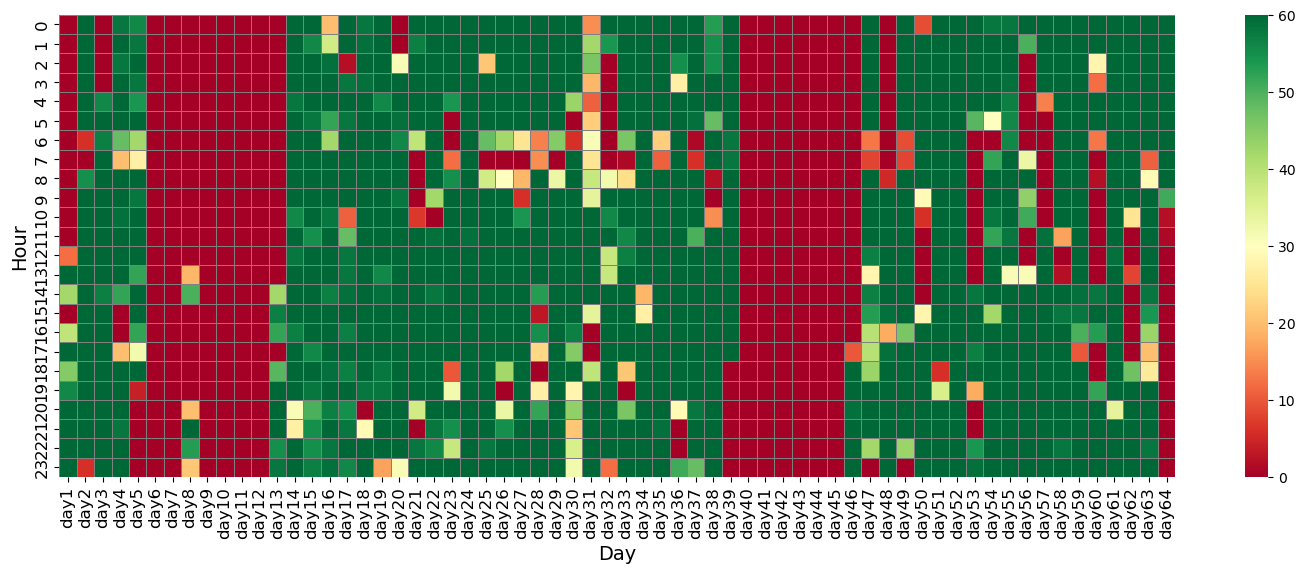

In [24]:
heatmap = generate_heatmap(df)

C:\Users\shantam.bhuraria@lilly.com\AppData\Local\Temp\ipykernel_25276\575991580.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_filtered_itemset = new_filtered_itemset.append({'support': largest_support, 'itemsets': largest_itemset}, ignore_index=True)


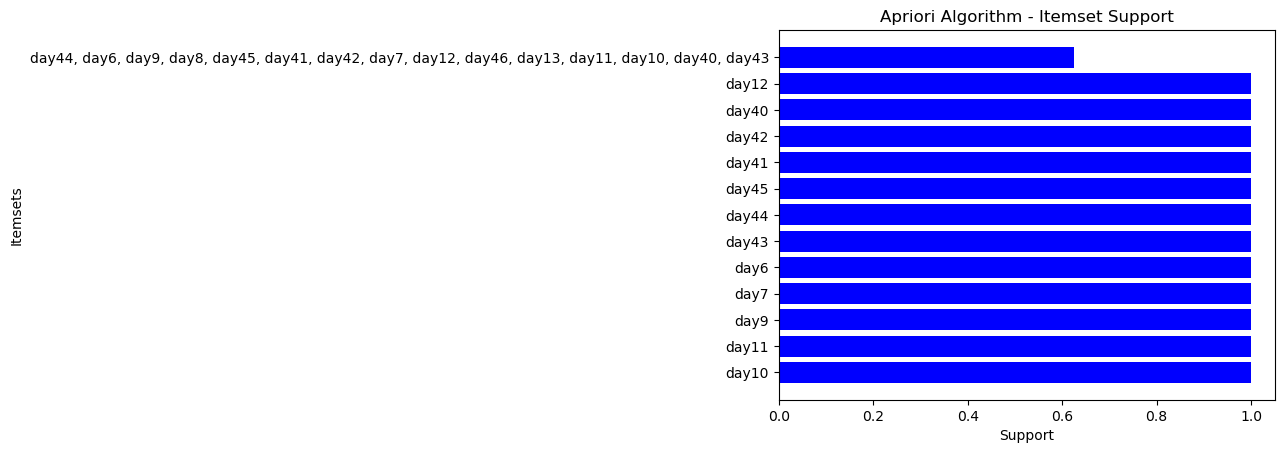

    support                                           itemsets
0     1.000                                              day10
1     1.000                                              day11
2     1.000                                               day9
3     1.000                                               day7
4     1.000                                               day6
5     1.000                                              day43
6     1.000                                              day44
7     1.000                                              day45
8     1.000                                              day41
9     1.000                                              day42
10    1.000                                              day40
11    1.000                                              day12
12    0.625  day44, day6, day9, day8, day45, day41, day42, ...


In [36]:
vertical_report = apriori_vertical_report(df)
print(vertical_report)

Day wise transaction of hours where compliance time is less than 40 min : 
 [(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16), (6, 7, 23), (0, 1, 2, 3), (7, 15, 16, 17), (6, 7, 17, 19, 20, 21, 22, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17), (20, 21), (), (0, 1, 6), (2, 10), (20, 21), (23,), (0, 1, 2, 23), (6, 7, 8, 9, 10, 20, 21), (9, 10), (5, 6, 7, 18, 19, 22), (), (2, 

C:\Users\shantam.bhuraria@lilly.com\AppData\Local\Temp\ipykernel_25276\2667202518.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_itemsets['itemsets'] = filtered_itemsets['itemsets'].apply(lambda x: ", ".join(str(item) for item in x))


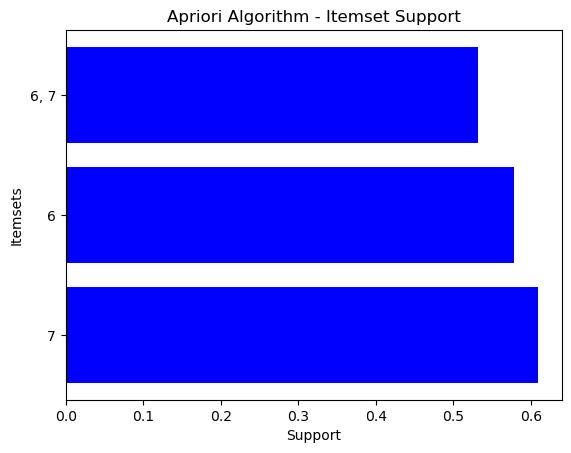

C:\Users\shantam.bhuraria@lilly.com\AppData\Local\Temp\ipykernel_25276\2667202518.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time_of_day'] = filtered_data['hour'].apply(get_time_of_day)


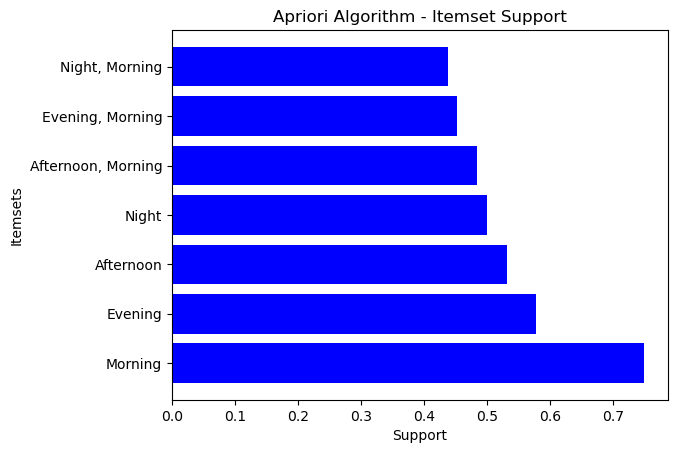

{'plot_reports': [],
 'Interpretations': [('',
   '\n-The patient is not compliant for the hours taken from itemset: 7, with a support of 0.609375.-The patient is not compliant for the hours taken from itemset: 6, with a support of 0.578125.-The patient is not compliant for the hours taken from itemset: 6, 7, with a support of 0.53125.'),
  ('\n',
   'The patient is least compliant during the following time of day: Morning, with a support of 0.75.')]}

In [31]:
apriori_horizontal_report(df)

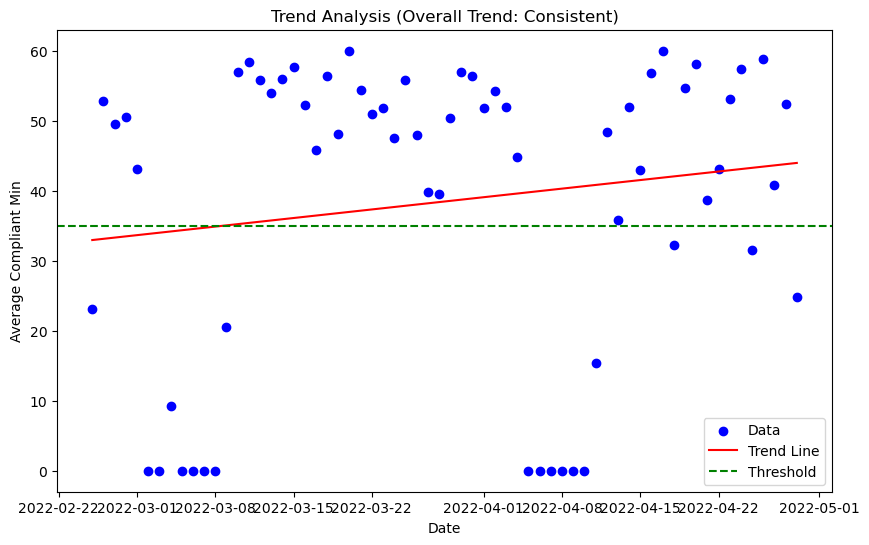

Overall Trend: Consistent


'Consistent'

In [32]:
trend_analysis(df)

In [ ]:
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_heatmap_new(df):
    # Create a copy of the dataframe
    patient_heat_map = df.copy()

    # Convert 'compliant_min' to integer
    patient_heat_map['compliant_min'] = patient_heat_map['compliant_min'].astype(int)

    # Get unique days in the DataFrame
    unique_days = patient_heat_map['day'].unique()
    unique_days = sorted(unique_days, key=lambda x: int(x[3:]))  # Sort the days numerically

    # Pivot the data
    pivot_data = patient_heat_map.pivot('hour', 'day', 'compliant_min')

    # Reorder the columns based on the sorted unique days
    pivot_data = pivot_data[unique_days]

    # Define the custom colormap with two colors: red and green
    cmap_custom = mcolors.ListedColormap(['red', 'green'])

    # Increase the figure size for better visibility
    plt.figure(figsize=(18, 6))

    # Creating the heatmap with the custom colormap
    sns.heatmap(pivot_data, cmap=cmap_custom, vmin=40, vmax=60, cbar=True, linewidths=0.5, linecolor='gray')

    # Add lines to separate hours and days
    plt.hlines(y=range(0, len(pivot_data.index)), xmin=0, xmax=len(pivot_data.columns), color='gray', linewidths=0.5)
    plt.vlines(x=range(0, len(pivot_data.columns)), ymin=0, ymax=len(pivot_data.index), color='gray', linewidths=0.5)

    # Customize the plot
    plt.title('Compliant Minutes Heatmap', fontsize=16)
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Hour', fontsize=14)

    # Increase the font size of the x-axis and y-axis labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Save the plot to a BytesIO object
    plot_bytes = io.BytesIO()
    plt.savefig(plot_bytes, format='png', dpi=400)  # Increase the dpi for higher resolution
    plt.show()
    plt.close()

    # Reset the buffer position to the start
    plot_bytes.seek(0)

    # Return the BytesIO object
    return plot_bytes


In [ ]:
heatmap2 = generate_heatmap_new(df)